<hr/> <h1 style="text-align: center;"><span style="color: #666699;"<em><strong>  Algorithmes de Classification et de Clustering du Jeu de Données des Maladies Cardiaques </strong></em></span></h1><hr/> 

## Importer les packages

In [1]:
# Importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from keras import models
from keras import layers
from keras.utils import to_categorical # type: ignore
from keras.optimizers import Adam # type: ignore

## Importer les données  

In [2]:
# Charger les données
data = pd.read_csv("Medicaldataset.csv")

In [3]:
# Afficher les premières lignes
data.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


## Prétraitement des données

> Supression des données abbérantes

- Lors de l'EDA, on avait remarqué que trois (03) patients avaient des rythmnes cardiaques de 1111 battements par minute ce qui est physiologiquement impossible. Ces valeurs seront supprimés.

- Pour les autres valeurs extrèmes mais probables, dans la péparation des données pour la modélisation, nous allons standardiser les données pour réduire plus ou moins l'impact de ces valeurs.

In [4]:
# Suppressions des valeurs de HeartRate supérieures à 1100
data_propre = data[data["Heart rate"] <1100]

In [5]:
# Dimensions
print(f"Taille avant supression : {data.shape[0]}")
print(f"Taille après supression : {data_propre.shape[0]}")

Taille avant supression : 1319
Taille après supression : 1316


> Définition du target et des features

In [6]:
# Target encodé
y = (data_propre['Result'] == "positive").astype(int)
# Features
X = data_propre.drop('Result',axis=1)

> Fonctions génériques

In [14]:
# Separation en train et test
def split_data(X,y):
    """
    X : Dataframe contenant les features
    y : Dataframe contenant le target
    X_train : Dataframe contenant les features de train
    X_test : Dataframe contenant les features de test
    y_train : Dataframe contenant les target de train
    y_test : Dataframe contenant les target de test"""
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)
    return X_train,X_test,y_train,y_test

In [15]:
def standardisation(X_train,X_test):
    """
    X_train : Serie ou dataframe contenant les observations des variables explicatives pour l'apprentissage
    X_test : Serie ou dataframe contenant les observations des variables explicatives pour le test
    Returns 
    -----------
    Retourne les données standardisés"""
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

In [17]:
# Fonction de mise en place du modèle
def get_model(name,X_train,y_train):
    
    if name.lower() == "tree" :
        model = DecisionTreeClassifier(random_state=42,max_depth=3)
        
    elif name.lower() == "forest" :
        model = RandomForestClassifier(n_estimators=10,random_state=42)
        
    elif name.lower() == "ada" :
        model = AdaBoostClassifier(n_estimators=10,random_state=42)
        
    elif name.lower() == "svc" :
        model = SVC(C=3,random_state=42,kernel="rbf")
        
    elif name.lower() == "knn" :
        model = KNeighborsClassifier(n_neighbors=3)
    
    elif name.lower() == "naive" :
        model = BernoulliNB()
        
    start = time.time()
    model.fit(X_train,y_train)
    curr_time = time.time() - start 
    print(f"Model entraîné |Temps d'entraînement du modèle : {curr_time}")
    return curr_time,model

In [18]:
# Fonction d'évaluation TRAIN vs TEST
def get_performance(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_pred_train,y_train)
    precision_train = precision_score(y_pred_train,y_train)
    recall_train = recall_score(y_pred_train,y_train)
    f1_train = f1_score(y_pred_train,y_train)
    roc_auc_train = roc_auc_score(y_pred_train,y_train)
    
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_pred_test,y_test)
    precision_test = precision_score(y_pred_test,y_test)
    recall_test = recall_score(y_pred_test,y_test)
    f1_test = f1_score(y_pred_test,y_test)
    roc_auc_test = roc_auc_score(y_pred_test,y_test)
    
    print(pd.DataFrame({"Metriques":["ACCURACY","PRECISION","RECALL","F1_SCORE","ROC_AUC_SCORE"],
                        "TRAIN":[accuracy_train,precision_train,recall_train,f1_train,roc_auc_train],
                        "TEST":[accuracy_test,precision_test,recall_test,f1_test,roc_auc_test]}))

In [19]:
# Fonction d'optimisation des hyperparamètres
def tune_hyperparameters(name,X_train, y_train, param_grid):
    """
    Cette fonction effectue l'ajustement des hyperparamètres pour RandomForestClassifier,SVMClassifier et 
    KNeighborsClassifier en utilisant GridSearchCV.
    
    Paramètres :
    - X_train : Caractéristiques de l'ensemble d'entraînement.
    - y_train : Étiquettes de l'ensemble d'entraînement.
    - values : Liste des valeurs de l'hyperparamètre à tester.
    
    Sortie :
    - best_param : Meilleure valeur pour l'hyperparamètre.
    - best_score : Meilleur score obtenu
    - results : DataFrame contenant les résultats de la recherche en grille.
    """
    if name.lower() == "forest": 
        # Créer un pipeline avec RobustScaler et RandomForestClassifier
        model = Pipeline([('scaler', RobustScaler()), ('forest', RandomForestClassifier(random_state=42))])
    
    if name.lower() == "svc": 
        # Créer un pipeline avec RobustScaler et SVC
        model = Pipeline([('scaler', RobustScaler()), ('svc', SVC(random_state=42))])
  
    if name.lower() == "knn": 
        # Créer un pipeline avec RobustScaler et KNeighborsClassifier
        model = Pipeline([('scaler', RobustScaler()), ('knn', KNeighborsClassifier())])
        
    # Effectuer GridSearchCV
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
    grid.fit(X_train, y_train)

    # Obtienir la meilleure valeur d'hyperparamètre
    best_param = grid.best_params_
    
    # Obtenir le meilleur score 
    best_score = grid.best_score_

    # Afficher les résultats de la recherche en grille
    results = pd.DataFrame(grid.cv_results_)

    return best_param, best_score, results

> Séparation en données d'apprentissage et de test

In [20]:
# Sépation en train et test
X_train,X_test,y_train,y_test = split_data(X,y)

> Vérification de la distribution des classes dans y_train et y_test

<Axes: ylabel='count'>

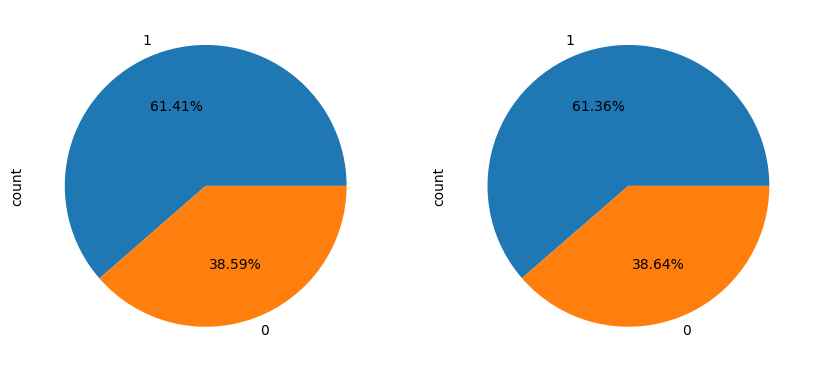

In [21]:
# Vérification de la distribution des classes dans y_train et y_test
fig,ax = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1)
y_train.value_counts().plot.pie(autopct = '%1.2f%%')
plt.subplot(1,2,2)
y_test.value_counts().plot.pie(autopct = '%1.2f%%')

> Standardiastion des données

Ici nous n'utiliserons par le StandardScaler puisqu'il est basé sur la moyenne et l'écart-type et ne sera donc pas assez robuste face à nos données qui ont des valeurs assez extrèmes et une distribution asymétrique. Le RobustScaler est plûtot basé sur la médiane et l'intervalle interquartile IQR qui sont des indicateurs plus robustes aux valeurs extrèmes. Sa formule mathématique de la normalisation est la suivante :

$$x_{robust} = \frac{x - \text{médiane}(x)}{\text{IQR}(x)}$$

In [22]:
# Standarisation des données avec StandardScaler (données anormalement dystribuées,valeurs extrèmes)
X_train_scaled,X_test_scaled = standardisation(X_train,X_test)

## Algorithmes de Classification

#### a. Arbre de Décision

In [23]:
# Implémenter le classifieur d’arbre de décision max_depth=3
time_tree,tree = get_model("tree",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.017602920532226562


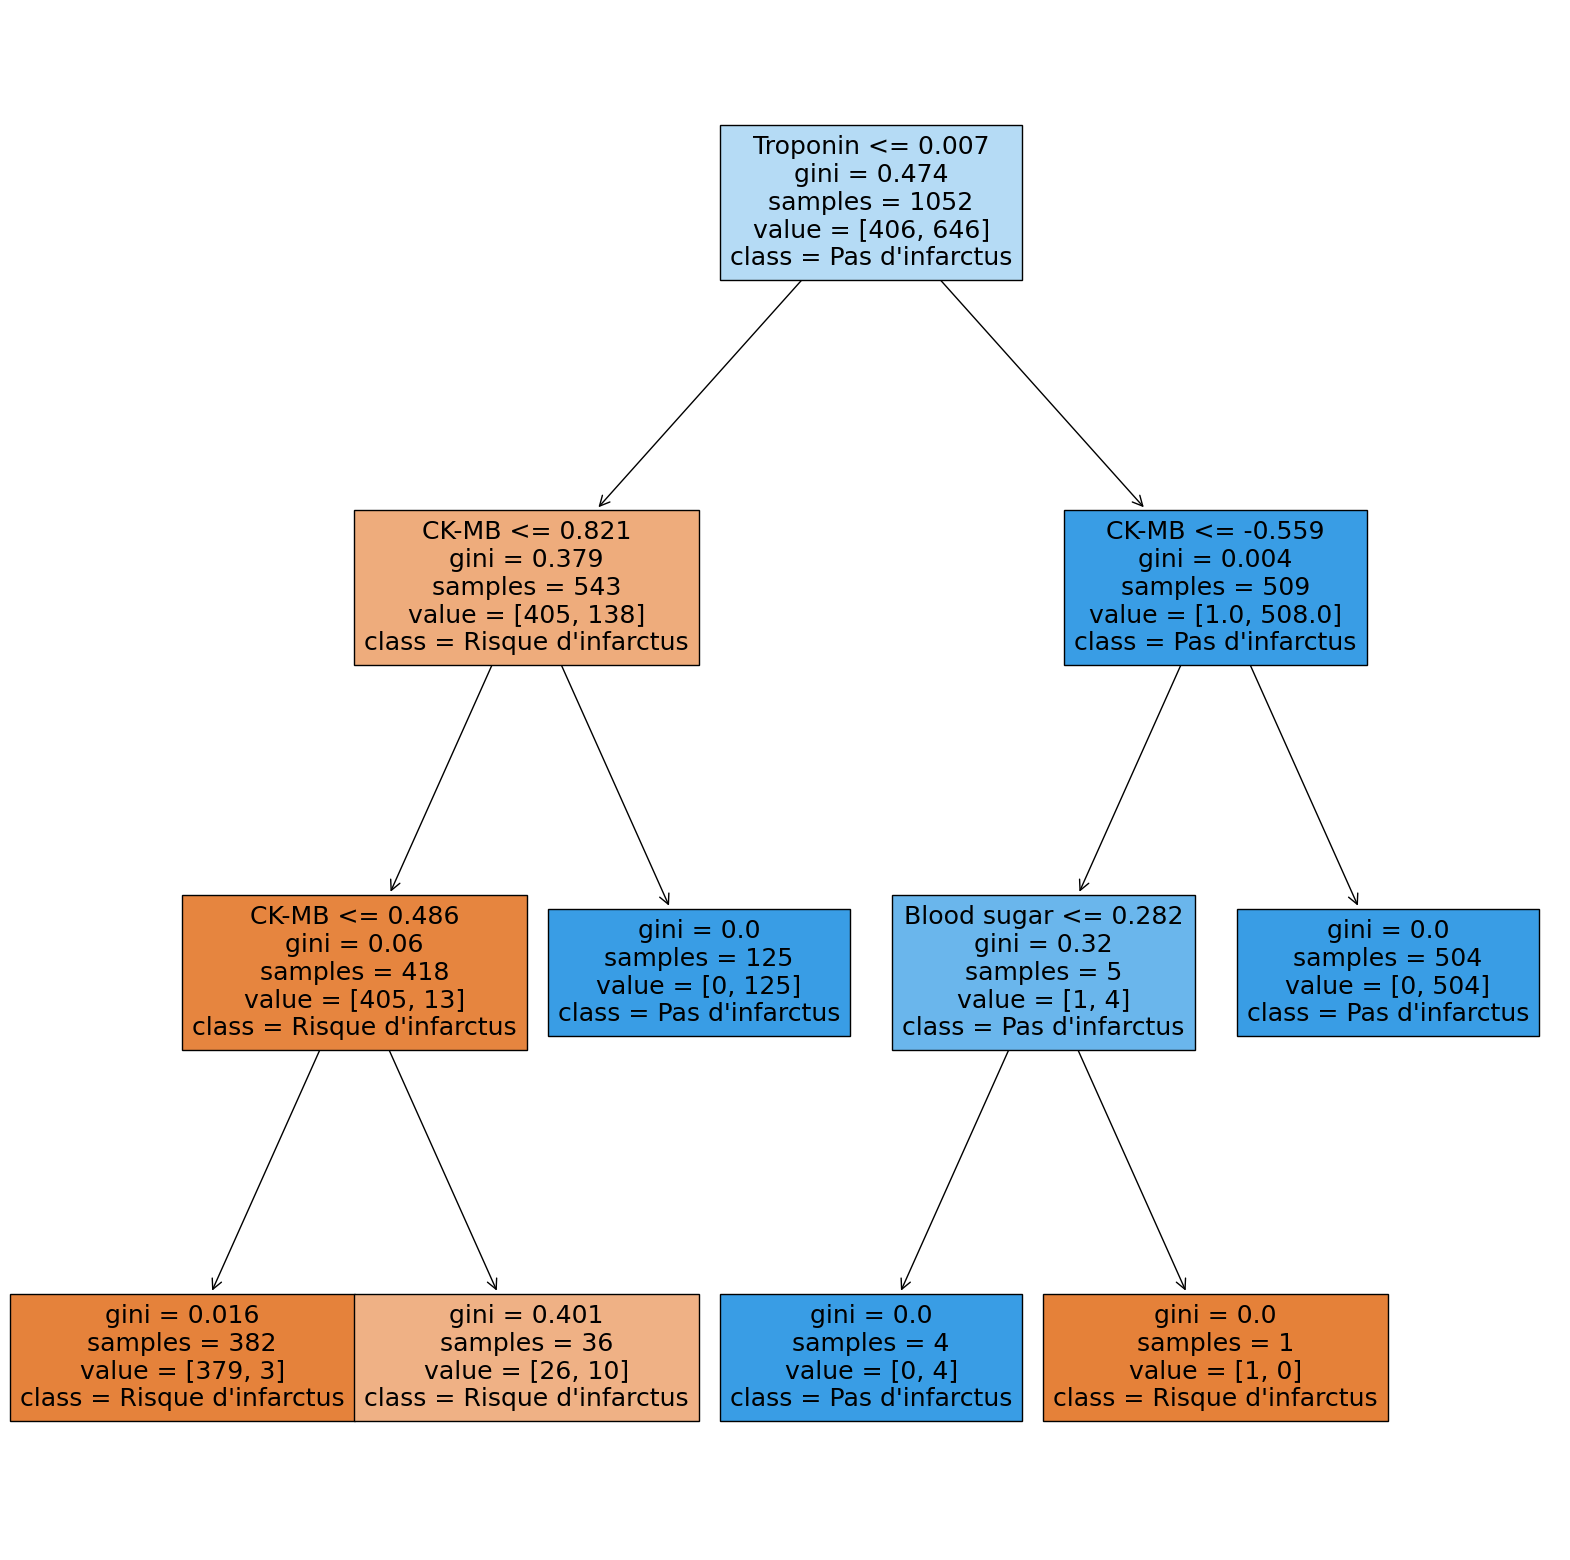

In [24]:
# Visualiser l'arbre de décision
plt.figure(figsize=(20,20))
plot_tree(tree,feature_names=list(X.columns),class_names=["Risque d'infarctus","Pas d'infarctus"],filled=True)
plt.show()

In [25]:
# Évaluer le classifieur en utilisant des métriques
get_performance(tree,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.987643  0.984848
1      PRECISION  0.979876  0.987654
2         RECALL  1.000000  0.987654
3       F1_SCORE  0.989836  0.987654
4  ROC_AUC_SCORE  0.984487  0.984023


#### b. Forêt Aléatoire

In [26]:
# Implémenter le classifieur de forêt aléatoire n_estimators=10
time_forest,forest = get_model("forest",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.03269004821777344


Text(0.5, 1.0, 'Random Forest features importances')

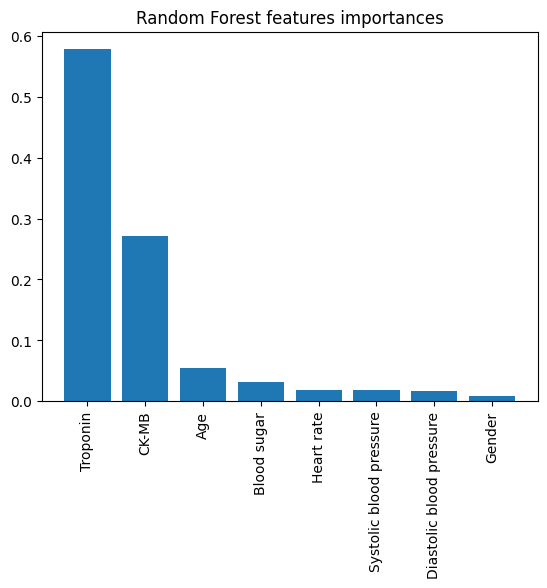

In [27]:
# Visualiser l’importance des caractéristiques
importances_forest = abs(forest.feature_importances_)
indices = np.argsort(importances_forest)[::-1]
plt.bar(x=X.columns[indices],height=importances_forest.reshape(8,)[indices])
plt.xticks(rotation=90)
plt.title("Random Forest features importances")

Du graphe, on remarque que les caractéristiques Age, CK-MB et surtout Troponin ont de grandes importances. Cela suggère que ces caractéristiques contribuent pas énormement à la prédiction du risque d'infarctus chez les patients.

In [28]:
# Ajuster les hyperparamètres
param_grid = {'forest__n_estimators': [10,30,50,100,200,300]}
# Optimisation des hyperparamètres
best_param, best_score, results = tune_hyperparameters("forest",X_train_scaled, y_train,param_grid)
print(f'Meilleur valeur de n_estimators: {best_param}')
print(f'Meilleur Score : {best_score}')
print(results[['param_forest__n_estimators', 'mean_test_score', 'std_test_score']])

Meilleur valeur de n_estimators: {'forest__n_estimators': 200}
Meilleur Score : 0.985745881290905
  param_forest__n_estimators  mean_test_score  std_test_score
0                         10         0.980993        0.009513
1                         30         0.982893        0.007728
2                         50         0.982898        0.007101
3                        100         0.983846        0.007107
4                        200         0.985746        0.006722
5                        300         0.984798        0.006979


In [190]:
# Évaluer le classifieur
get_performance(forest,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.998099  0.988636
1      PRECISION  0.998452  0.993827
2         RECALL  0.998452  0.987730
3       F1_SCORE  0.998452  0.990769
4  ROC_AUC_SCORE  0.997994  0.988915


#### c. AdaBoost

In [90]:
# Implémenter un classifieur AdaBoost
time_adaboost,adaboost = get_model("ada",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.07916951179504395


c:\Users\KHAIRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Text(0.5, 1.0, 'AdaBoost Estimators importances')

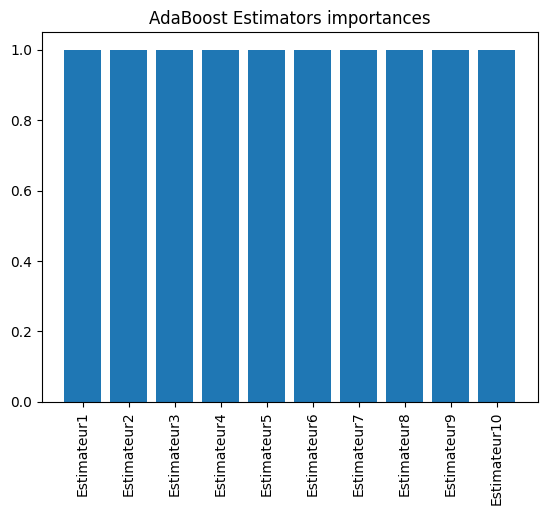

In [192]:
# Visualiser l’importance des classificateurs faibles
importances_classificateurs = adaboost.estimator_weights_
plt.bar(x=range(len(importances_classificateurs)),height=importances_classificateurs)
plt.xticks(range(len(importances_classificateurs)),
           ["Estimateur"+str(i+1) for i in range(len(importances_classificateurs))],rotation=90)
plt.title("AdaBoost Estimators importances")

Text(0.5, 1.0, 'AdaBoost Estimators errors')

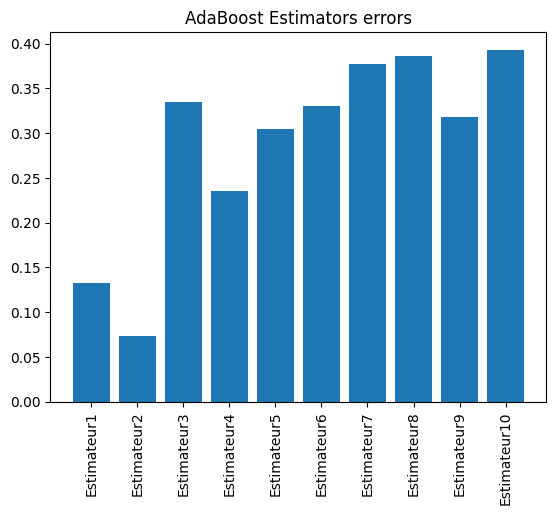

In [193]:
# Visualiser les erreurs des classificateurs faibles
errors = adaboost.estimator_errors_
plt.bar(x=range(len(errors)),height=errors)
plt.xticks(range(len(errors)),["Estimateur"+str(i+1) for i in range(len(errors))],rotation=90)
plt.title("AdaBoost Estimators errors")

Text(0.5, 1.0, 'AdaBoost features importances')

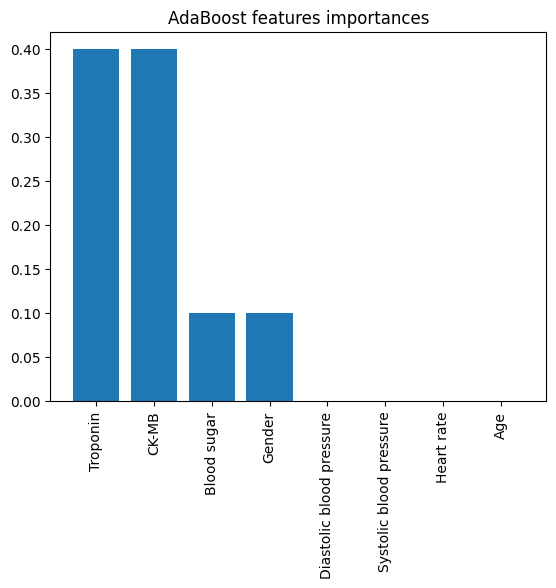

In [91]:
# Visualiser l’importance des caractéristiques
importances_ada = abs(adaboost.feature_importances_)
indices = np.argsort(importances_ada)[::-1]
plt.bar(x=X.columns[indices],height=importances_ada.reshape(8,)[indices])
plt.xticks(rotation=90)
plt.title("AdaBoost features importances")

Du graphe, on remarque que les caractéristiques Blood Sugar, CK-MB et surtout Troponin ont de grandes importances. Cela suggère que ces caractéristiques contribuent pas énormement à la prédiction du risque d'infarctus chez les patients.

In [92]:
# Évaluer le classifieur
get_performance(adaboost,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.986692  0.988636
1      PRECISION  0.981424  0.993827
2         RECALL  0.996855  0.987730
3       F1_SCORE  0.989080  0.990769
4  ROC_AUC_SCORE  0.984005  0.988915


#### d. SVM

In [29]:
# Implémenter un classifieur SVM C=3
time_svc,svc = get_model("svc",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.04300975799560547


In [30]:
# Visualiser la séparation des classes dans l’espace des caractéristiques
# Reduction des dimensions des données
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [31]:
def separation_marge(model,X_test,y_test):
    # Tracé de la frontière de décision
    fig, ax = plt.subplots(figsize=(6, 6))

    # Positionnement des points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    xlim = ax.get_xlim() # obtenir les limites de l'axe des x
    ylim = ax.get_ylim() # obtenir les limites de l'axe des y
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50)) # Crétion de deux grilles xx et yy
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 

    # Tracer la frontière de décision
    ax.contour(xx, yy, Z, levels=[0], colors='k')
    ax.set_title(f"Frontière de décision") 

Model entraîné |Temps d'entraînement du modèle : 0.0920867919921875


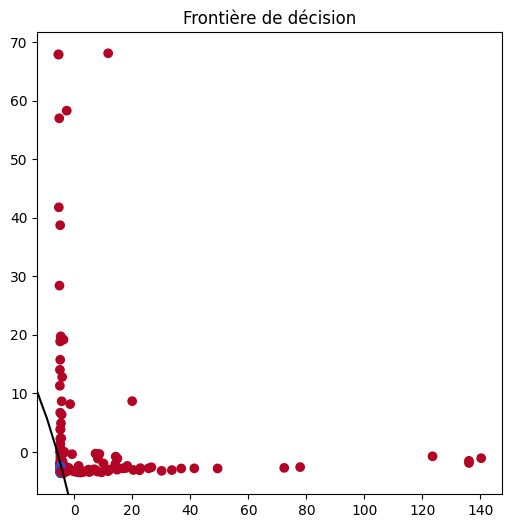

In [32]:
t,new_svc = get_model("svc",X_train_pca,y_train)
# Visualisation de la marge entre les classes
separation_marge(new_svc,X_test_pca,y_test)

In [33]:
# Ajuster les hyperparamètres
param_grid = {'svc__C': [3,10,50,100,200,300,500]}
# Optimisation des hyperparamètres
best_param, best_score, results = tune_hyperparameters("svc",X_train_scaled, y_train,param_grid)
print(f'Meilleur valeur de C: {best_param}')
print(f'Meilleur Score : {best_score}')
print(results[['param_svc__C', 'mean_test_score', 'std_test_score']])

Meilleur valeur de C: {'svc__C': 500}
Meilleur Score : 0.9391649740464907
  param_svc__C  mean_test_score  std_test_score
0            3         0.825100        0.022369
1           10         0.867867        0.031505
2           50         0.905872        0.021462
3          100         0.920144        0.020540
4          200         0.929655        0.017411
5          300         0.937260        0.016314
6          500         0.939165        0.018878


In [34]:
#  Évaluer le classifieur
get_performance(svc,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.846008  0.856061
1      PRECISION  0.761610  0.783951
2         RECALL  0.984000  0.976923
3       F1_SCORE  0.858639  0.869863
4  ROC_AUC_SCORE  0.852507  0.857865


#### e. K-Nearest Neighbors (KNN)

In [35]:
# Implémenter un classifieur KNN n_neighbors=3
time_knn,knn = get_model("knn",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.021715641021728516


In [37]:
def decison_frontiere(model,X_test,y_test):
    # Tracé de la frontière de décision
    fig, ax = plt.subplots(figsize=(6, 6))

    # Positionnement des points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    xlim = ax.get_xlim() # obtenir les limites de l'axe des x
    ylim = ax.get_ylim() # obtenir les limites de l'axe des y
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                         np.linspace(ylim[0], ylim[1], 200)) # Crétion de deux grilles xx et yy
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 

    # Tracer la frontière de décision
    ax.contour(xx, yy, Z, levels=[0], colors='k')
    ax.set_title(f"Frontière de décision") 

Model entraîné |Temps d'entraînement du modèle : 0.0032782554626464844


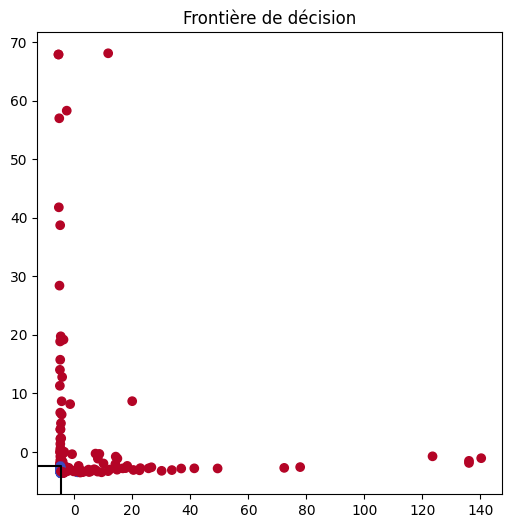

In [38]:
# Visualiser les régions de décision
_,new_knn = get_model("knn",X_train_pca,y_train)
# Visualisation de la marge entre les classes
decison_frontiere(new_knn,X_test_pca,y_test)

In [39]:
# Ajuster les hyperparamètres si nécessaire
param_grid = {'knn__n_neighbors': [3,10,50,100,200,300]}
# Optimisation des hyperparamètres
best_param, best_score, results = tune_hyperparameters("knn",X_train_scaled, y_train,param_grid)
print(f'Meilleur valeur de n_neighbors: {best_param}')
print(f'Meilleur Score : {best_score}')
print(results[['param_knn__n_neighbors', 'mean_test_score', 'std_test_score']])

Meilleur valeur de n_neighbors: {'knn__n_neighbors': 10}
Meilleur Score : 0.8117896637327917
  param_knn__n_neighbors  mean_test_score  std_test_score
0                      3         0.792760        0.019807
1                     10         0.811790        0.025255
2                     50         0.806044        0.026749
3                    100         0.793703        0.025945
4                    200         0.767104        0.023302
5                    300         0.746193        0.019657


In [40]:
#  Évaluer le classifieur
get_performance(knn,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.908745  0.795455
1      PRECISION  0.905573  0.808642
2         RECALL  0.943548  0.850649
3       F1_SCORE  0.924171  0.829114
4  ROC_AUC_SCORE  0.901172  0.784416


#### f. Naive Bayes

In [41]:
# Implémenter un classifieur Naive Bayes
time_naive,naive_model = get_model("naive",X_train_scaled,y_train)

Model entraîné |Temps d'entraînement du modèle : 0.0048525333404541016


In [44]:
# Probabilités a priori : probabilités des classes avant les observations
prior_probabilities = naive_model.class_log_prior_
prior_probabilities

array([-0.95209523, -0.48764889])

In [42]:
# Probabilités postérieures : probabilités des variables pour chaque classe
posterior_probabilities = naive_model.feature_log_prob_
posterior_probabilities

array([[-0.98738665, -6.01126717, -0.70299948, -0.72300014, -0.67854838,
        -0.69314718, -1.02083459, -5.31811999],
       [-0.59895997, -6.4738907 , -0.75357892, -0.76678043, -0.7055697 ,
        -0.71498892, -0.53371944, -0.24144268]])

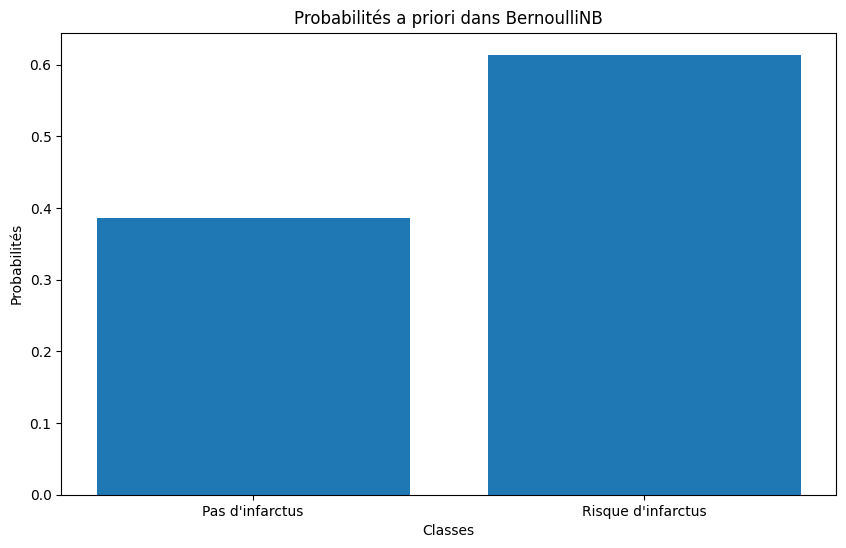

In [45]:
# Visualiser les probabilités a priori
plt.figure(figsize=(10, 6))
plt.bar(range(len(prior_probabilities)), np.exp(prior_probabilities))
plt.xticks(range(2),["Pas d'infarctus","Risque d'infarctus"],rotation=0)
plt.xlabel('Classes')
plt.ylabel('Probabilités')
plt.title("Probabilités a priori dans BernoulliNB")
plt.show()

Les probabilités a priori représentent les croyances initiales du modèle sur la probabilité qu'une observation appartienne à chaque classe, avant d'avoir appris des données d'entraînement. On pourrait croire que le modèle a calculé les probabilités initiales en se basant sur les proportions des différentes classes.

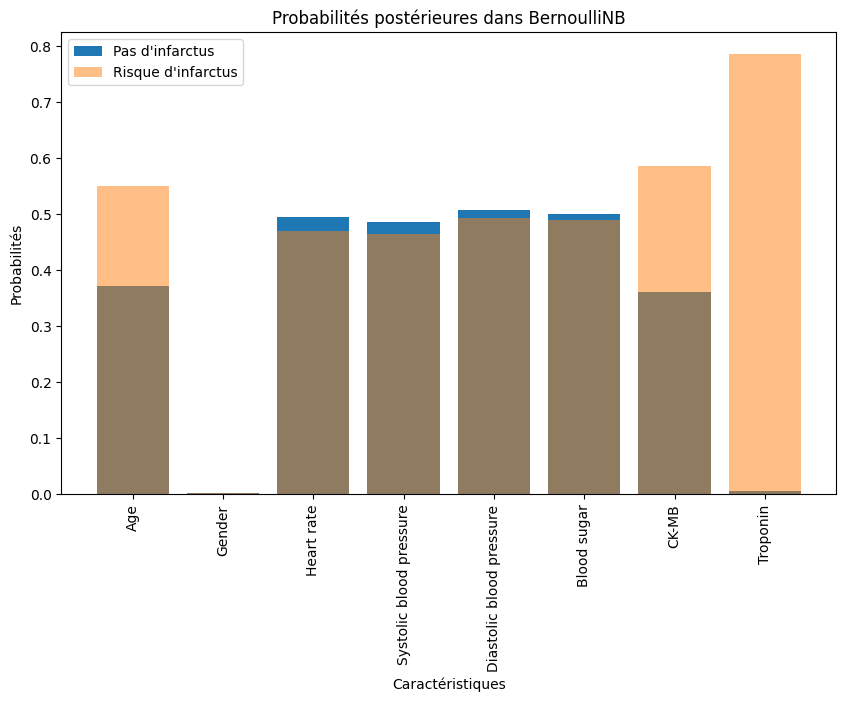

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(posterior_probabilities[0])), np.exp(posterior_probabilities[0]), label="Pas d'infarctus")
plt.bar(range(len(posterior_probabilities[1])), np.exp(posterior_probabilities[1]), label="Risque d'infarctus", alpha=0.5)
plt.xticks(range(len(X.columns)),list(X.columns),rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Probabilités')
plt.title("Probabilités postérieures dans BernoulliNB")
plt.legend()
plt.show()

Les probabilités postérieures représentent les croyances ajustées du modèle après avoir appris les données d'entraînement et plus précisément des caractéristiques. On constate que les caractéristiques Age, CK-MB et surtout Troponin ont des probablités très fortes d'être présente ou absente dans la classe des patients présentant un rique d'infarctus. Les probabilités d'être présente ou absente dans la classe des patients présentant un rique d'infarctus et dans celle de ceux ne présentant aucun rique est pratiquement la même pour chaque autre caractéristique.

Cela suggère que les caractéristiques Age, CK-MB et surtout Troponin sont des informations discriminantes importantes pour la classification des patients en fonction de leur risque d'infarctus.

In [49]:
# Évaluer le classifieur
''' F1_SCORE : utile en cas de désiquiilibre des classes
    ROC_AUC_SCORE : le taux de vrais positifs contre le taux de faux positifs
    RECALL : Le pourcentage de vrais positifs détectés parmi tous les cas positifs réels'''
get_performance(naive_model,X_train_scaled,X_test_scaled,y_train,y_test)

       Metriques     TRAIN      TEST
0       ACCURACY  0.867871  0.893939
1      PRECISION  0.786378  0.833333
2         RECALL  0.998035  0.992647
3       F1_SCORE  0.879654  0.906040
4  ROC_AUC_SCORE  0.871946  0.890855


## Algorithmes de Classification

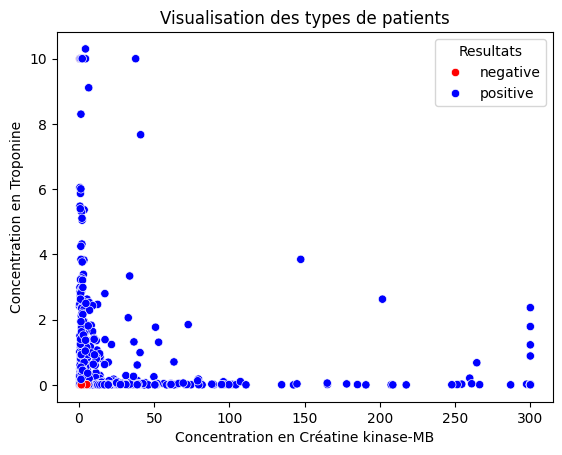

In [50]:
# Visualiser le jeu de données dans une grille 2D avec des points en utilisant des caractéristiques pertinentes
palette_colors = {"positive": "blue", "negative": "red"}
sns.scatterplot(data=data_propre,x="CK-MB",y="Troponin", hue="Result",palette=palette_colors)
plt.legend(title="Resultats")
plt.title("Visualisation des types de patients")
plt.xlabel("Concentration en Créatine kinase-MB")
plt.ylabel("Concentration en Troponine")
plt.show()

In [51]:
# Sélectionner uniquement les variables quantitatives
data_numeric = data_propre.drop("Result",axis=1)

# Normaliser les données
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_numeric)

#### a. k-Means Clustering

In [52]:
# Appliquer k-Means avec un nombre prédéfini de clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=2, random_state=42)

In [53]:
# Visualiser les résultats du clustering
# Ajouter les labels de cluster au DataFrame
data_propre['kmean_label'] = kmeans.labels_
data_propre

C:\Users\KHAIRI\AppData\Local\Temp\ipykernel_14296\1905699849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_propre['kmean_label'] = kmeans.labels_


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result,kmean_label
0,64,1,66,160,83,160.0,1.80,0.012,negative,0
1,21,1,94,98,46,296.0,6.75,1.060,positive,0
2,55,1,64,160,77,270.0,1.99,0.003,negative,0
3,64,1,70,120,55,270.0,13.87,0.122,positive,0
4,55,1,64,112,65,300.0,1.08,0.003,negative,0
...,...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,negative,0
1315,66,1,84,125,55,149.0,1.33,0.172,positive,0
1316,45,1,85,168,104,96.0,1.24,4.250,positive,1
1317,54,1,58,117,68,443.0,5.80,0.359,positive,0


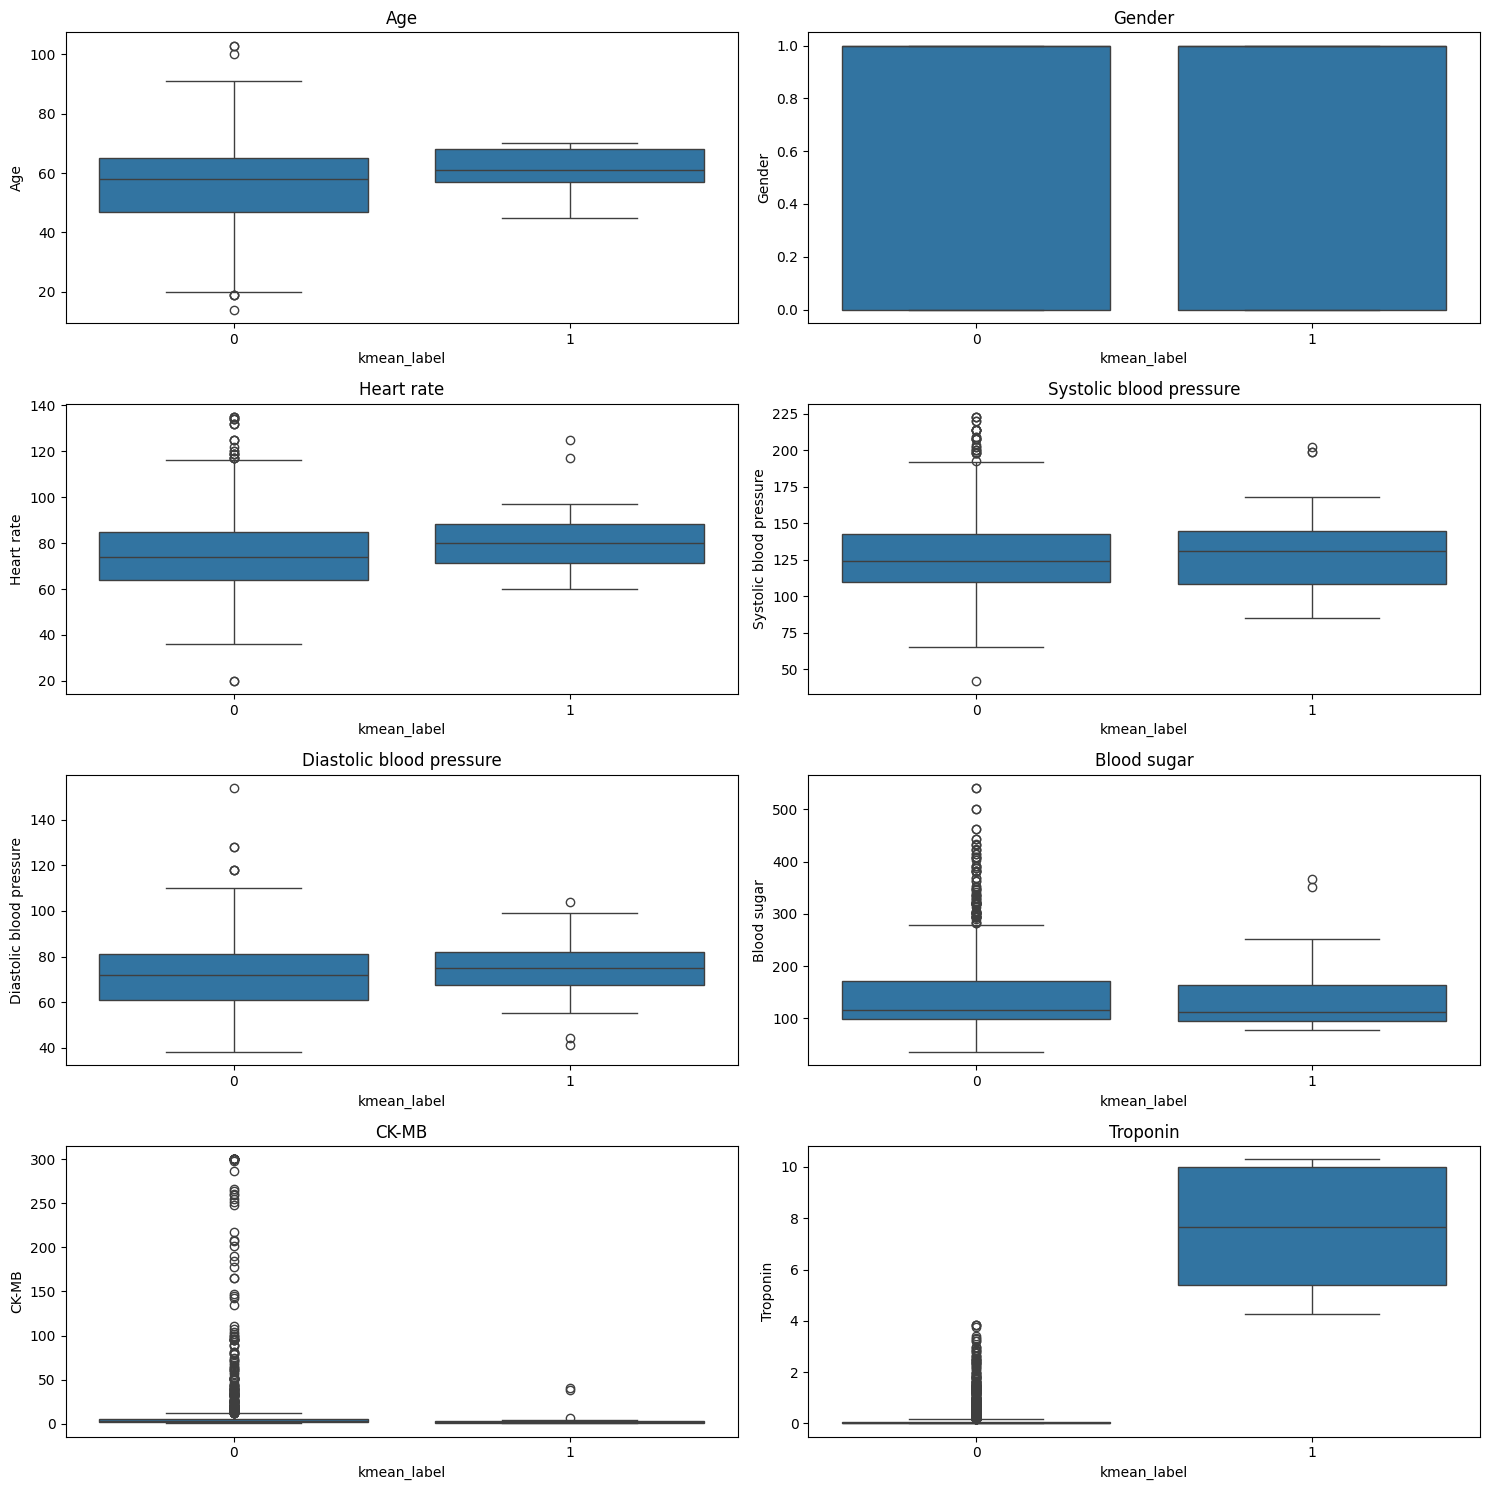

In [54]:
# Visualiser les groupes par rapport aux variables quantitatives
plt.figure(figsize=(15, 15))
for i, column in enumerate(data_numeric.columns, start=1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='kmean_label', y=column, data=data_propre)
    plt.title(column)

plt.tight_layout()
plt.show()

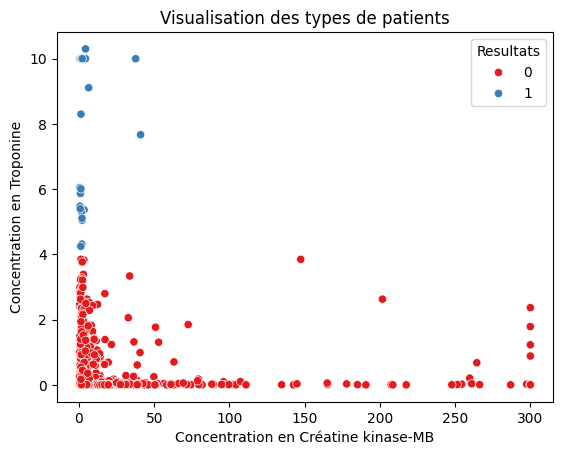

In [55]:
# Visualiser les groupes identifiés
sns.scatterplot(data=data_propre,x="CK-MB",y="Troponin", hue="kmean_label",palette='Set1')
plt.legend(title="Resultats")
plt.title("Visualisation des types de patients")
plt.xlabel("Concentration en Créatine kinase-MB")
plt.ylabel("Concentration en Troponine")
plt.show()

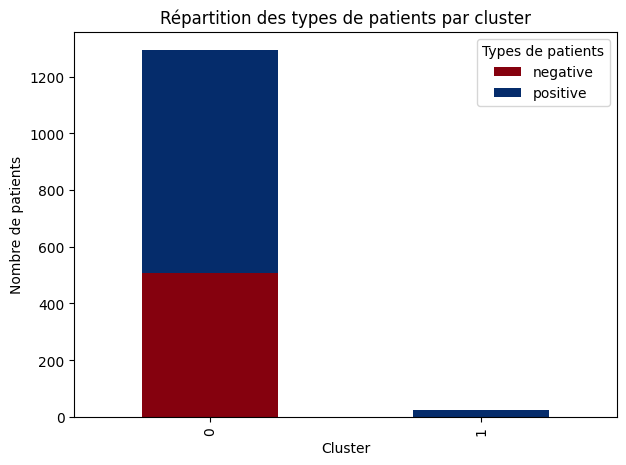

In [62]:

custom_palette = ["#85010e", "#052c6b", "#59040d"]

# Créer une table de contingence entre cluster_label et Result
contingency_table = pd.crosstab(data_propre['kmean_label'], data_propre['Result'])

# Tracer le barplot
contingency_table.plot(kind='bar', stacked=True , figsize=(7, 5), color=custom_palette)

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel('Nombre de patients')
plt.title('Répartition des types de patients par cluster')

# Afficher la légende
plt.legend(title='Types de patients')

# Afficher le graphique
plt.show()

In [63]:
# Explorer les métriques (silhouette score, etc.) pour évaluer la qualité du clustering
''' Score d'inertie : à quel point les échantillons sont proches de leur centre de cluster
    Score de la silouhette :  à quel point les échantillons sont proches de leurs propres clusters par rapport aux autres clusters'''
silhouette_kmean = silhouette_score(data_scaled, kmeans.labels_)
print(f"Score d'inertie : {kmeans.inertia_}")
print(f"Score de la silhouette :{silhouette_kmean}")

Score d'inertie : 255513.25968000773
Score de la silhouette :0.8708886669480461


In [65]:
# Itérer pour trouver le nombre optimal de clusters en utilisant les métriques d’évaluation
start = time.time()
inerties = []
silhouettes = []
K = range(2, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(data_scaled)
    inerties.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(data_scaled, kmeanModel.labels_))
time_kmean = time.time()-start
print(f"Temps de calcul : {time_kmean}")

Temps de calcul : 0.6558051109313965


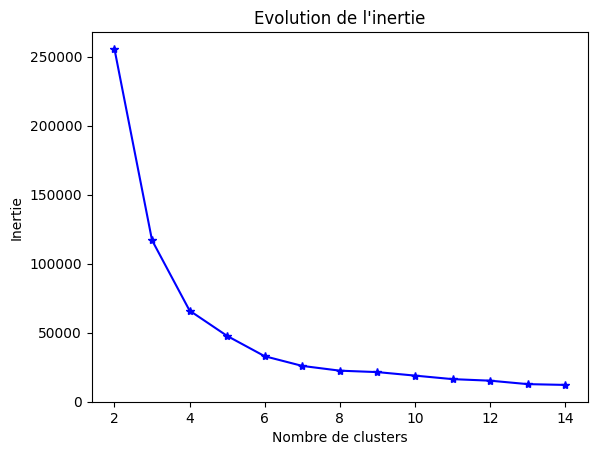

In [66]:
# Tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(range(2, 15), inerties,"b-*")
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("Evolution de l'inertie")
plt.show()

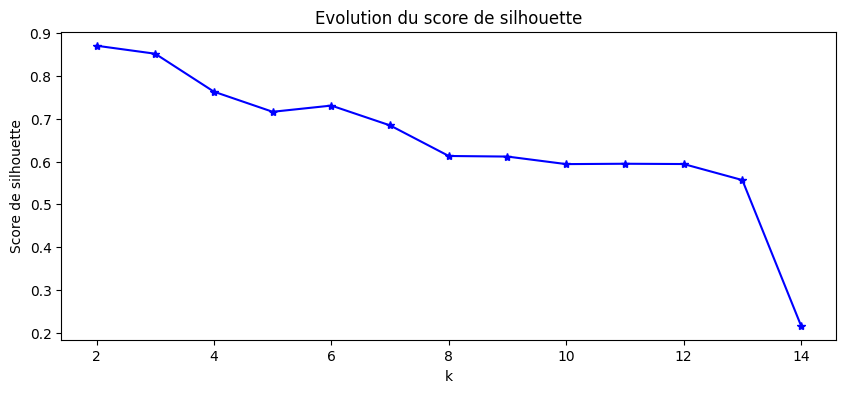

In [67]:
# Graphique du score de silhouette
plt.figure(figsize=(10,4))
plt.plot(K, silhouettes, 'b-*')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Evolution du score de silhouette')
plt.show()

### Expliquer les limites de K-means avec un exemple de jeu de données
- Sensibilité aux valeurs extrèmes vu qu'il se base sur la distance euclidienne pour regrouper les individus en clusters.

- Sensible au choix du nombre de clusters

#### b.Clustering Hiérarchique Agglomératif

In [68]:
# Appliquer le clustering hiérarchique agglomératif avec un nombre prédéfini de clusters
# Calcul de la matrice de similarité et dissimilarité
similarity_matrix = linkage(data_scaled, method='ward', metric='euclidean')
# Mise en place du modèle
clusters = fcluster(similarity_matrix, 2, criterion='maxclust')

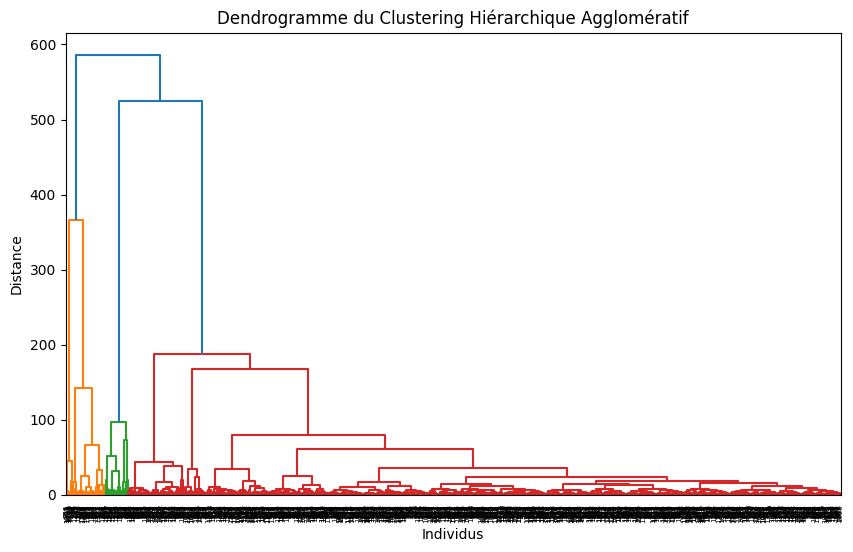

In [94]:
# Visualiser les dendrogrammes et les résultats du clustering
plt.figure(figsize=(10, 6))
dendrogram(similarity_matrix)
plt.title('Dendrogramme du Clustering Hiérarchique Agglomératif')
plt.xlabel('Individus')
plt.ylabel('Distance')
plt.show()

In [70]:
# Utiliser les métriques d’évaluation pour analyser la qualité du clustering
silhouette_cah = silhouette_score(data_scaled, clusters)
print(f"Score de la silhouette :{silhouette_cah}")

Score de la silhouette :0.7897868883357642


In [71]:
# Ajouter les informations de cluster dans le DataFrame
data_propre['cah_label'] = clusters

C:\Users\KHAIRI\AppData\Local\Temp\ipykernel_14296\440876770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_propre['cah_label'] = clusters


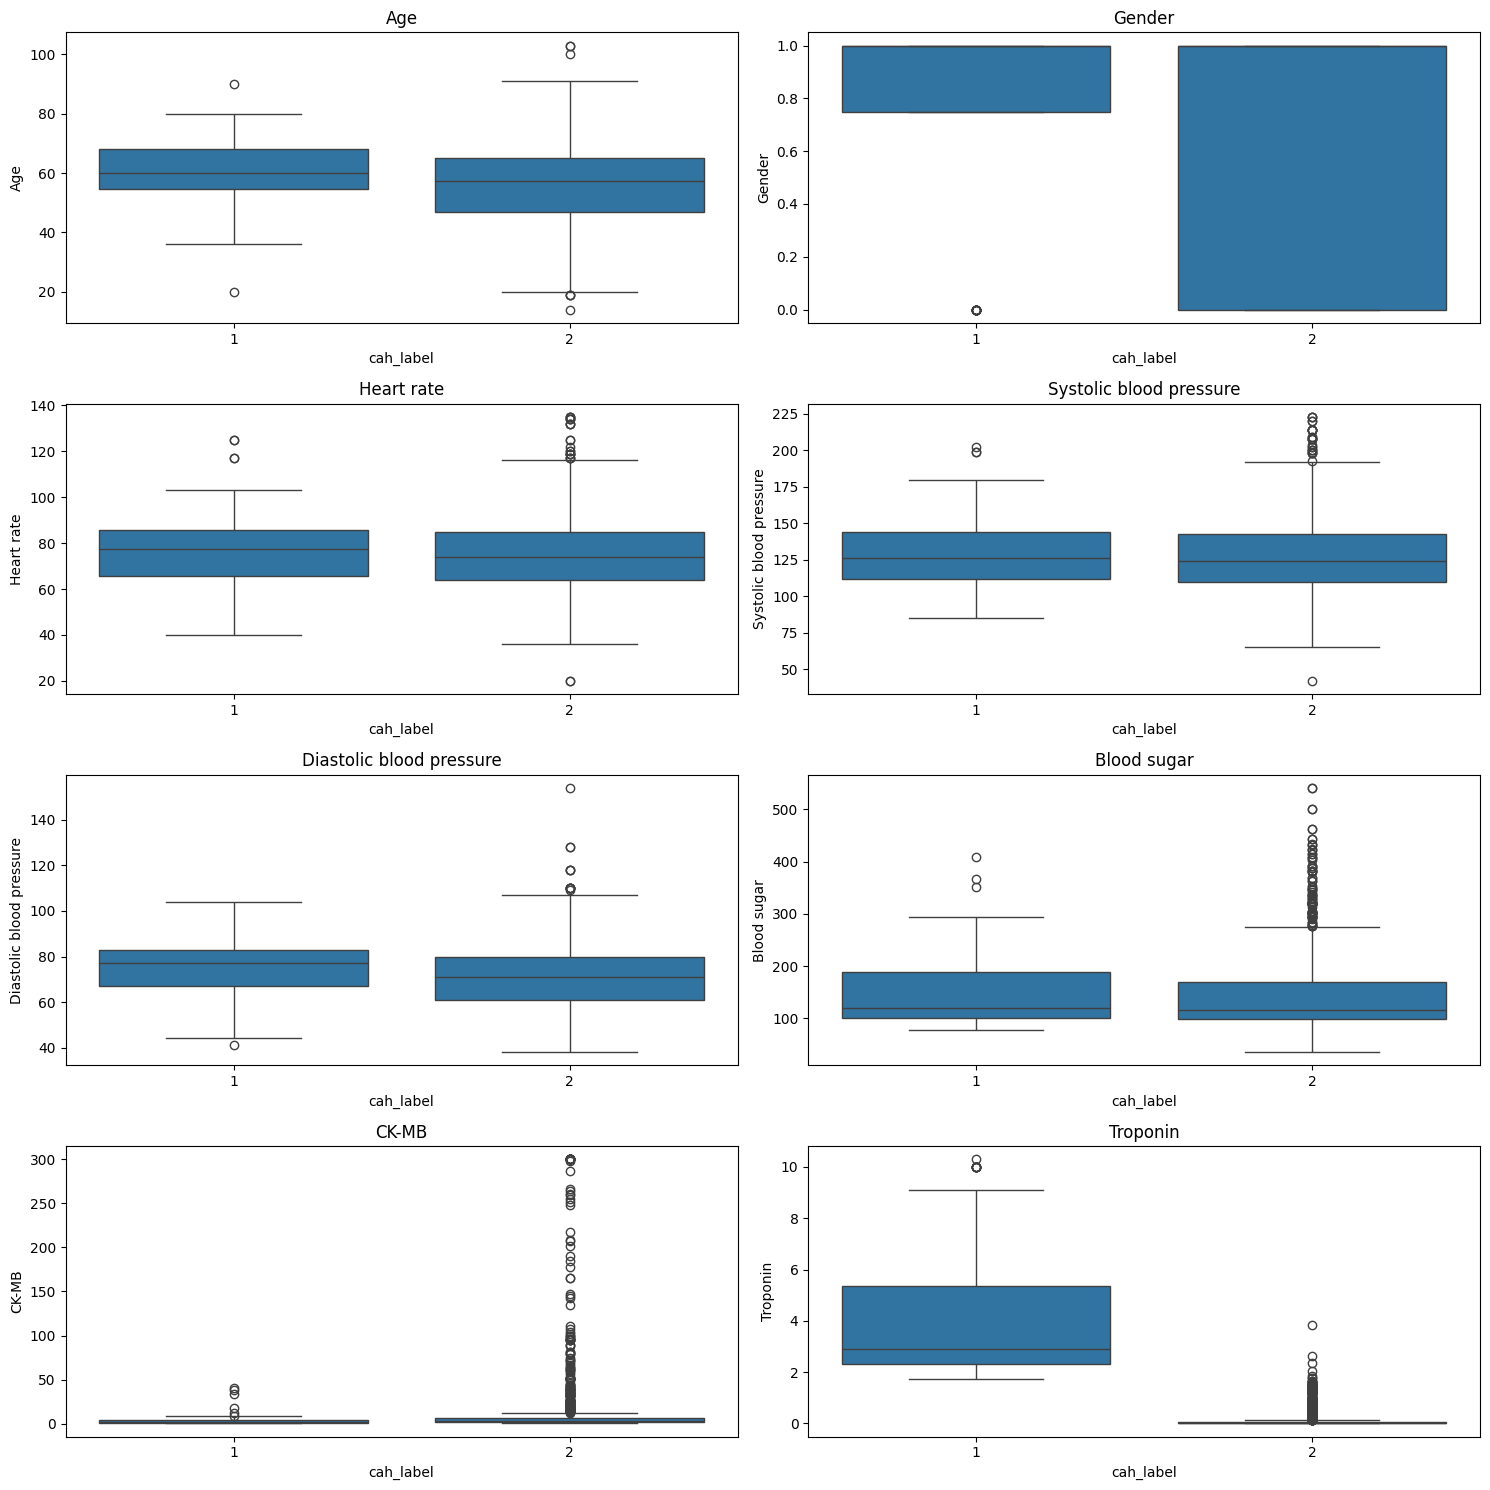

In [72]:
# Visualiser les groupes par rapport aux variables quantitatives
plt.figure(figsize=(15, 15))
for i, column in enumerate(data_numeric.columns, start=1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='cah_label', y=column, data=data_propre)
    plt.title(column)

plt.tight_layout()
plt.show()

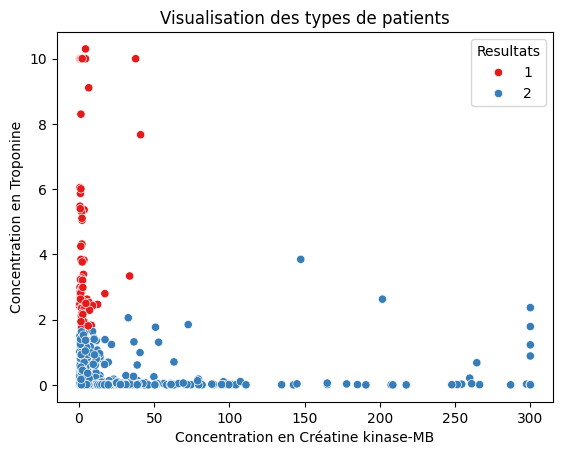

In [73]:
# Visualiser les groupes identifiés
sns.scatterplot(data=data_propre,x="CK-MB",y="Troponin", hue="cah_label",palette='Set1')
plt.legend(title="Resultats")
plt.title("Visualisation des types de patients")
plt.xlabel("Concentration en Créatine kinase-MB")
plt.ylabel("Concentration en Troponine")
plt.show()

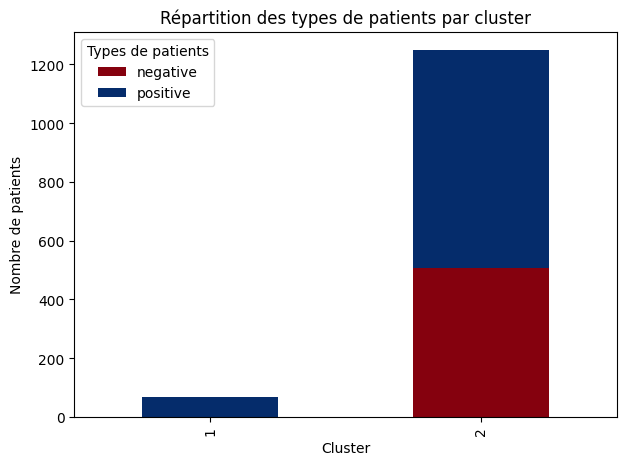

In [80]:
custom_palette = ["#85010e", "#052c6b", "#3357FF"]

# Créer une table de contingence entre cah_label et Result
contingency_table = pd.crosstab(data_propre['cah_label'], data_propre['Result'])

# Tracer le barplot
contingency_table.plot(kind='bar', stacked=True , figsize=(7, 5), color=custom_palette)

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel('Nombre de patients')
plt.title('Répartition des types de patients par cluster')

# Afficher la légende
plt.legend(title='Types de patients')

# Afficher le graphique
plt.show()

In [75]:
# Itérer pour trouver le nombre optimal de clusters 
start = time.time()
silhouette_scores = []
for num_clusters in range(2, 11):
    clusters = fcluster(linkage(data_scaled, method='ward', metric='euclidean'), num_clusters, criterion='maxclust')
    silhouette = silhouette_score(data_scaled, clusters)
    silhouette_scores.append(silhouette)
time_cah = time.time()-start
print(f"Temps de calcul : {time_cah}")

Temps de calcul : 0.699934720993042


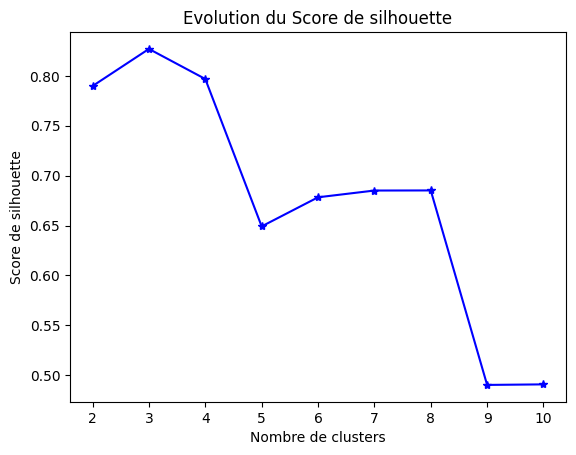

In [76]:
# Tracer le graphique du score de silhouette moyen pour chaque nombre de clusters
plt.plot(range(2, 11), silhouette_scores, 'b-*')
plt.title("Evolution du Score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.show()

### Expliquer les limites du clustering agglomératif avec un exemple de jeu de données
- Sensibilité aux valeurs extrèmes vu qu'il se base sur la distance pour regrouper les individus en clusters

## Analyse Comparative

#### a. Algorithmes de classification

In [95]:
# Comparer les performances des différents classifieurs
accs = []
precisions = []
recalls = []
f1s = []
roc_aucs = []
times = [time_tree,time_forest,time_adaboost,time_svc,time_knn,time_naive]

modeles = {"Arbre de Decision":tree,"Forêt Aleatoire":forest,"AdaBoost":adaboost,"SVM":svc,
           "KNN":knn,"Naive Bayes":naive_model}
for name,model in modeles.items():
    y_pred = np.round(model.predict(X_test_scaled))
    acc = accuracy_score(y_pred,y_test)
    precision = precision_score(y_pred,y_test)
    recall = recall_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test)
    roc_auc = roc_auc_score(y_pred,y_test)
    
    accs.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    
metriques = pd.DataFrame({"Modeles":list(modeles.keys()),"Accuracy":accs,"Precision":precisions,"Recall":recalls,
                         "F1 Score":f1s,"ROC AUC":roc_aucs,
                          "Temps d'execution":times})
metriques

,Modeles,Accuracy,Precision,Recall,F1 Score,ROC AUC,Temps d'execution
0,Arbre de Decision,0.984848,0.987654,0.987654,0.987654,0.984023,0.017603
1,Forêt Aleatoire,0.988636,0.993827,0.987730,0.990769,0.988915,0.032690
2,AdaBoost,0.988636,0.993827,0.987730,0.990769,0.988915,0.079170
3,SVM,0.856061,0.783951,0.976923,0.869863,0.857865,0.043010
4,KNN,0.795455,0.808642,0.850649,0.829114,0.784416,0.021716
5,Naive Bayes,0.893939,0.833333,0.992647,0.906040,0.890855,0.004853


### Analyse des forces et faiblesses de chaque classifieur

 La performance(accuracy) la plus basse étant de 79%, tous les modèles ont relativement bien convergés. Etant donné qu'on est dans un contexte sanitaire, les faux négatifs auront des conséquences graves. Donc le recall sera à privilégier dans le choix du modèle. 


1. `Arbre de Décision` :
    
    - Ce modèle a pour principe de diviser progressivement les données en sous-ensembles homogènes en fonction des caractéristiques, permettant ainsi de prendre des décisions basées sur une série de conditions. 

    - L'entraînement est relativement court (3ème modèle en terme de rapidité).
    
    - On observe une précision (accuracy) très satisfaisant de 0.98 lors du test. Cela signifie que sur 10 patients, le modèle classera correctement au moins 9 d'entre eux.
    
    - En terme de faiblesse, ce modèle n'est pas très robuste et peut facilement overtifité surtout si l'arbre de décison est trop profond.

2. `Forêt Aleatoire` :
        
    - Ce modèle a pour principe de combiner plusieurs arbres de décision pour améliorer la généralisation du modèle. 
    
    - L'entraînement est relativement court.
    
    - Il a obtenu les meilleurs scores pour toutes les métriques se retrouvent ainsi à égalité avec le modèle AdaBoost.
    
    - En terme de faiblesse, ce modèle est moins interprétable que les arbres de décision individuels.
    
3. `AdaBoost` :
    
    - C'est un modèle ensembliste complexe.
    
    - Il a pour principe de combiner plusieurs modèles faibles (classifieurs faibles) pour former un modèle fort.
    
    - 5ème modèle en terme de rapidité
    
4. `Support Vecteur Machine(SVM)` :
    
    - C'est un modèle classique facile à expliquer.
    
    - Il a pour principe de représenter les données dans l'espace et de trouver un hyperplan qui sépare les données en classes distinctes 
    
    - 6ème modèle en terme de rapidité : relativement lent
    
    - Performances relativement acceptables 
    
5. `K-Nearest Neighbors (KNN)` :
    
    - C'est un modèle classique facile à expliquer.
    
    - Il a pour principe de mémoriser toutes les instances du jeu de données d'entraînement. Pour une nouvelle instance (point de données) dont la classe doit être prédite.
    
    - Modèle le plus rapide du fait de sa méthode d'apprentissage basée sur l'instance.
    
    - Performances relativement acceptables 
    
    - Sensibilité aux valeurs extrèmes vu qu'il se base sur la distance.

6. `Naive Bayes` :
    
    - C'est un modèle classique facile à expliquer.
    
    - Il a pour principe d'estimer les probabilités a priori et postérieures à partir des données d'apprentissage.
    
    - Deuxième Modèle le plus rapide
    
    - Performances relativement acceptables.
    

### Choisir le modèle le plus performant
En somme, le modèle d'Arbre de Décision semble être le choix le plus performant.

In [96]:
# Ecrivons le programme de classification de manière explicite avec le modèle d'Abre de décision choisi

# Fonction de rassemblement du dossier patient
def get_infos_patient():
    print("Veuillez saisir les informations suivantes :")
    age = float(input("Âge : "))
    gender = input("Genre (M/F) : ").upper()
    if gender == "M" :
        gender_encoded = 1 
    else :
        gender_encoded = 0
    heart_rate = float(input("Fréquence cardiaque : "))
    systolic_bp = float(input("Pression artérielle systolique : "))
    diastolic_bp = float(input("Pression artérielle diastolique : "))
    blood_sugar = float(input("Taux de sucre dans le sang : "))
    ck_mb = float(input("Taux de CK-MB : "))
    troponin = float(input("Taux de troponine : "))
    donnees = np.array([[age, gender_encoded, heart_rate, systolic_bp, diastolic_bp, blood_sugar, ck_mb, troponin]])
    print("Les informations ont bien été enregistrées ")
    return donnees

# Fonction de détection de l'infarctus
def infarctus_detector(donnees):
    donnees_scaled = scaler.transform(donnees)
    prediction = tree.predict(donnees_scaled)[0]
    print(" ")
    if prediction == 0 :
        print("Resultat : Le patient ne risque pas d'avoir un infarctus")
    else :
        print("Resultat : Le patient risque d'avoir un infarctus")

### Un exemple de patient 
Voici un exemple fictif de valeurs pour un patient sain :

Age : 35 ans
Gender : Male
Heart rate : 72 bpm
Systolic blood pressure : 120 mmHg
Diastolic blood pressure : 80 mmHg
Blood sugar : 90 mg/dL
CK-MB : 5 U/L
Troponin : 0.01 ng/mL

In [102]:
donnee_patient_sain = get_infos_patient()

Veuillez saisir les informations suivantes :
Les informations ont bien été enregistrées 


Voici un exemple fictif de valeurs pour un patient souffrant d'une maladie cardiaque :

Age : 60 ans
Gender : Female
Heart rate : 100 bpm
Systolic blood pressure : 160 mmHg
Diastolic blood pressure : 95 mmHg
Blood sugar : 200 mg/dL
CK-MB : 200 U/L
Troponin : 2 ng/mL

In [103]:
donnee_patient_non_sain = get_infos_patient()

Veuillez saisir les informations suivantes :
Les informations ont bien été enregistrées 


In [104]:
infarctus_detector(donnee_patient_sain)

 
Resultat : Le patient ne risque pas d'avoir un infarctus


c:\Users\KHAIRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [105]:
infarctus_detector(donnee_patient_non_sain)

 
Resultat : Le patient risque d'avoir un infarctus


c:\Users\KHAIRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
